In [41]:
import json
from multiprocessing.sharedctypes import Value
from typing import List, Dict
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

from typeguard import typechecked
from operator import itemgetter

from paretochart.paretochart import pareto 


In [42]:
# CONST
FILE_NAME         = ['german','adult','compas']
PRE_PROC_METHOD_B = ['baseline','Reweighing','DisparateImpactRemover','OptimPreproc','LFR']
PRE_PROC_METHOD_F = ['fairboost']
CLASSIFIER        = ['Logistic Regression', 'Random Forest']
METRICS           = ['accuracy', 'disparate_impact', 'average_odds_difference']  

In [43]:
#@typechecked
def read_json_file(json_file_name):
    """
    Read a json file that contains the results of the Fairboost evaluation (baseline and fairboost) 
    Then create a dataframe only with the nodes results 

    :param json_file_name: an Json file containing the results of the baseline or Fairboost
    """
    json_data = pd.read_json(json_file_name)
    if 'results' in json_data:
        json_data = json_data['results']
    return(json_data)   

In [44]:
#@typechecked
def is_jsonkey_in(json_data, json_key) -> bool:
    """
    Check whether a key is a json node. Then return true if the key is found otherwise false

    :param json_data: an child from a Json node
    :param json_key: key name to validate if it is contained in the node
    """
    return( True if json_key in json_data else False)  

In [45]:
#@typechecked
def split_json_by_file(json_data, file_name):
    """
    Create a subset of the Json based on node names - File names. 
    
    :param json_data: an Json file containing the results of the baseline or Fairboost
    :param file_name: Fairboost is evaluated using three files (german, adults, compas)
    """
    return json_data[file_name]

In [46]:
#@typechecked
def split_json_by_prepro(json_data, pre_proc_meth, HAS_KEY: bool):
    """
    Create a subset of the Json based on node names containing the pre-processing technique names (i.e., Reweighing). 
    
    :param json_data: a set of the Json file containing the results of the baseline or Fairboost filtered by filename
    :param pre_proc_meth: preprocessing technique name
    :param HAS_KEY: if a node child contains a dict as value
    """
    if not HAS_KEY: 
        r = (json_data[pre_proc_meth])
    else:
        # double check a key exist
        if is_jsonkey_in(json_data[pre_proc_meth][0], "results"):
             r = [ e['results'] for e in json_data[pre_proc_meth] ]
    
    return (r)

    

In [47]:
#@typechecked
def split_json_by_classifier(json_data, classifier):
    """
    Create a subset of the Json based on node names containing the classifier technique names (i.e., Random Forest). 
    
    :param json_data: a set of the Json file containing the results of the baseline or Fairboost filtered by classifier name
    :param classifier: classifier name
    """    
    return(json_data[classifier])

In [48]:
#@typechecked
def split_json_by_metrics(json_data, file_, prepo_, classif_, metrics_) -> pd.DataFrame:
    """
    Search for the metrics (accuracy, disparate impact, average odds difference) and the
    Create a dataframe that contains data filename, preprocessing tehcnique name, classifier name
    and the metrics (accurrarcy). 
    
    :param json_data: a set of the Json file containing the results of the baseline or Fairboost filtered by classifier name
    :param file_: File name used for computing Fareboost
    :param prepo_: Preprocessing technique names used by Fairboost
    :param classif_: classifier name used by Fairboost
    :param metrics_: is a array containing the metrics names
    """       
    t1 = []
    t2 = []
    t3 = []
    t4 = []    
    t5 = []
    t6 = []
    t7 = []
    results_acc_metric = json_data[metrics_[0]]
    results_di_metric  = json_data[metrics_[1]]
    results_aod_metric = json_data[metrics_[2]]
    
    # assuming that all the three metrics childs list has the same number of results
    nb_of_metrics_computed = len(json_data[metrics_[0]])

    for n in range (nb_of_metrics_computed):
        t1.append(file_)
        t2.append(prepo_)
        t3.append(classif_)
        t4.append(results_acc_metric[n])
        t5.append(results_di_metric[n])
        t6.append(results_aod_metric[n])
        t7.append(abs(1-results_di_metric[n]))
    ds_ = pd.DataFrame({"ds":t1, "preproc":t2, "classifier": t3,  "acc": t4, "di": t5, "aod": t6,"absdi": t7})
    return ds_

In [49]:
#@typechecked
def create_full_dataframe_from_json(json_file, type_of_preproc_method = ""):
    """
    Iterate the Json file that contains the baseline and/or fairboost computed (fairness) results
    then, create the dataframe having the evaluated metrics results
    
    :param json_file: Json file containing the results of the baseline or Fairboost filtered by nodes named results
    :param type_of_preproc_method: Preprocessing technique names used by Fairboost
    """   
    #Const
    PRE_PROC_METHOD = PRE_PROC_METHOD_B
    # add this ['baseline','fairboost'] below if baseline is required to be evaluate from fairboost json
    if type_of_preproc_method == 'FAIRBOOST': PRE_PROC_METHOD = PRE_PROC_METHOD_F 
    
    # Create an empty dataframe
    ds_stats = pd.DataFrame(columns = ['ds', 'preproc', 'classifier', 'acc', 'di', 'aod', 'absdi'])
    
    #Iterate the JSON file
    json_data = read_json_file(json_file)
    index_ = 0
    for file_ in FILE_NAME: 
        # Split the JSON file by filename (german, adults, compas)
        json_set_by_file_name = split_json_by_file(json_data, file_)
        for prepo_ in PRE_PROC_METHOD:
            # Split the JSON file by preprocessing method
            if  prepo_ == 'baseline' and type_of_preproc_method == "" :
                    json_set_by_prepoc =  split_json_by_prepro(json_set_by_file_name, prepo_, False) 
            else:
                json_set_by_prepoc =  split_json_by_prepro(json_set_by_file_name, prepo_, True)
            for classif_ in CLASSIFIER:
                # Split the JSON file by classifier
                if isinstance(json_set_by_prepoc,dict):
                    json_set_by_classifier = split_json_by_classifier(json_set_by_prepoc,classif_)
                    ds_= split_json_by_metrics(json_set_by_classifier, file_, prepo_,classif_, METRICS)
                    ds_stats= pd.concat([ds_stats, ds_]) 
            
                if isinstance(json_set_by_prepoc,list): 
                    # Search from the metrics and create the dataframes
                    for l in json_set_by_prepoc:
                      x = []
                      if len(l) > 0:
                          #print(l)
                          json_set_by_classifier = split_json_by_classifier(l,classif_)
                          ds_= split_json_by_metrics(json_set_by_classifier, file_, prepo_,classif_, METRICS)
                          ds_stats= pd.concat([ds_stats, ds_])  
    return (ds_stats)  
    

In [50]:
# Create the baseline dataframe
baseline_ = create_full_dataframe_from_json('baseline_splits.json')
print(baseline_)

        ds   preproc           classifier       acc        di       aod  \
0   german  baseline  Logistic Regression  0.733333  0.859408 -0.184721   
1   german  baseline  Logistic Regression  0.680000  0.848077 -0.166834   
2   german  baseline  Logistic Regression  0.666667  0.992691 -0.009911   
3   german  baseline  Logistic Regression  0.670000  0.873096 -0.131045   
4   german  baseline  Logistic Regression  0.683333  0.770116 -0.266140   
..     ...       ...                  ...       ...       ...       ...   
5   compas       LFR        Random Forest  1.000000  0.742412  0.000000   
6   compas       LFR        Random Forest  1.000000  0.741697  0.000000   
7   compas       LFR        Random Forest  1.000000  0.779188  0.000000   
8   compas       LFR        Random Forest  1.000000  0.739225  0.000000   
9   compas       LFR        Random Forest  1.000000  0.770472  0.000000   

       absdi  
0   0.140592  
1   0.151923  
2   0.007309  
3   0.126904  
4   0.229884  
..       

In [51]:
# Create the fairbost dataframe
fairboost_ = create_full_dataframe_from_json('fairboost_splits.json',"FAIRBOOST")
print(fairboost_)

        ds    preproc           classifier       acc        di       aod  \
0    adult  fairboost  Logistic Regression  0.791715  0.000000 -0.151244   
1    adult  fairboost  Logistic Regression  0.788849  0.000000 -0.150990   
2    adult  fairboost  Logistic Regression  0.785641  0.000000 -0.151309   
3    adult  fairboost  Logistic Regression  0.788030  0.000000 -0.149597   
4    adult  fairboost  Logistic Regression  0.794786  0.000000 -0.153741   
..     ...        ...                  ...       ...       ...       ...   
5   compas  fairboost        Random Forest  0.681187  0.692223 -0.253094   
6   compas  fairboost        Random Forest  0.651515  0.809757 -0.130356   
7   compas  fairboost        Random Forest  0.656566  0.700127 -0.241651   
8   compas  fairboost        Random Forest  0.655303  0.820654 -0.140360   
9   compas  fairboost        Random Forest  0.638889  0.810134 -0.120350   

       absdi  
0   1.000000  
1   1.000000  
2   1.000000  
3   1.000000  
4   1.000000

In [52]:
# https://python-graph-gallery.com/bubble-plot/

#@typechecked
def plot_bubble(data_, filename_ , preproc_, classifier_, title_ ='', color_="green"):
    """
    Plot the metrics resulting from the evaluation of the baseline and fairboost

    :param data_: dataset resulted from the JSON
    :param filename_: Dataset used for Fairboost
    :param classif_: classifier name used by Fairboost
    :param title_: is a array containing the metrics names
    :param color_: is a array containing the metrics names
    """       
    data_ = data_.loc[ (data_['ds'] == filename_) & (data_['classifier'] == classifier_) & (data_['preproc'] == preproc_) ]
    
    sns.set_theme()
    # Change color with c and alpha
    plt.scatter(data_['acc'], data_['absdi'], s=200 , c= color_, marker="o")
    plt.xlabel("Accuracy")
    plt.ylabel("Disparate impact ")
    plt.title(title_)
    # show the graph
    plt.show()  


In [53]:
# https://python-graph-gallery.com/custom-legend-with-matplotlib

# @typechecked
def plot_markers(data_, filename_ , classifier_, title_ =''):
    """
    Plot the metrics resulting from the evaluation of the baseline and fairboost

    :param data_: dataset resulted from the JSON
    :param filename_: Dataset used for Fairboost
    :param classif_: classifier name used by Fairboost
    :param title_: is a array containing the metrics names
    :param color_: is a array containing the metrics names
    """     
    data_ = data_.loc[ (data_['ds'] == filename_) & (data_['classifier'] == classifier_)  ]   
    sns.set_theme()
    g = sns.lmplot(
        data = data_,
        x = "acc", y="absdi", hue="preproc",
        height=5,
    )
    plt.title(title_)


In [54]:
# https://python-graph-gallery.com/boxplot/
# https://app.mode.com/modeanalytics/reports/8f48bee3ee4e/details/notebook
#@typechecked
def plot_box(data_, filename_ , preproc_,   title_ ='', metric_='acc'):
    """
    Plot the metrics resulting from the evaluation of the baseline and fairboost

    :param data_: dataset resulted from the JSON
    :param filename_: Dataset used for Fairboost
    :param preproc_: Preprocessing technique names used by Fairboost
    :param title_: is a array containing the metrics names
    :param color_: is a array containing the metrics names
    """  
    data_ = data_.loc[ (data_['ds'] == filename_)]# & (data_['preproc'] == preproc_) ]   
    if len(data_) > 0:
        
        sns.set(style="whitegrid")
        f, ax = plt.subplots(figsize=(8, 8))
        
        ax = sns.violinplot(x=metric_, y="preproc",hue="classifier", data=data_)
       
        sns.despine(left=True)
        f.suptitle(title_, fontsize=18, fontweight='bold')
        ax.set_ylabel("Pre-Processing",size = 8, alpha=0.7)
        ax.set_xlabel(metric_,size = 8, alpha=0.7)
        plt.legend(loc="upper right")
        plt.show()

In [55]:
#https://seaborn.pydata.org/generated/seaborn.relplot.html
#@typechecked
def plot_relplot(data_, filename_ , classifier_,   title_ =''):
    # Plot accuracy vs disparate impact relation group by classifier based on pre-processing technique 
    """
    Plot the metrics resulting from the evaluation of the baseline and fairboost grouup by pre-processing 
    techniques and then it compares the classifiers

    :param data_: dataset resulted from the JSON
    :param filename_: Dataset used for Fairboost
    :param title_: is a array containing the metrics names
    """  
    data_ = data_.loc[ (data_['ds'] == filename_) ]#& (data_['classifier'] == classifier_ )  ]   
    
    if len(data_) > 0: 
        sns.set_theme(style="white")
        sns.relplot(x="acc", y="absdi", hue="preproc",  col="classifier" ,data=data_)
                #sizes=(10, 100), alpha=.5, palette="muted",
                #height=6, data=data_, col="preproc", col_wrap=1)
        plt.ylabel("Disparate impact")
        plt.xlabel("Accuracy")
        plt.title(title_, loc='left')
        plt.show()
    

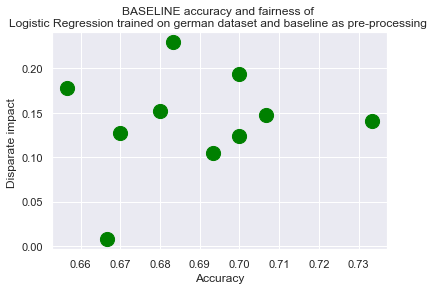

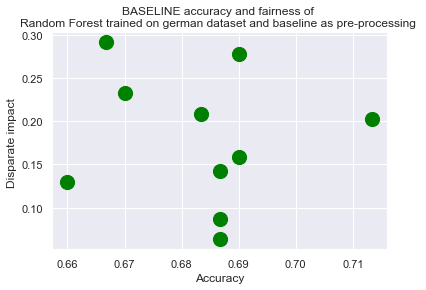

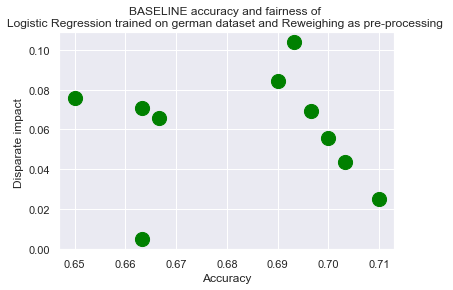

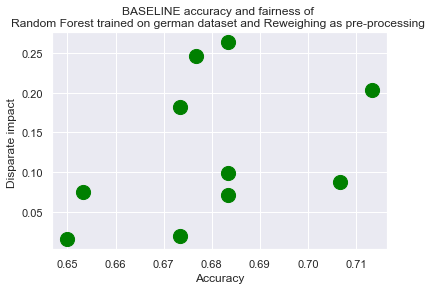

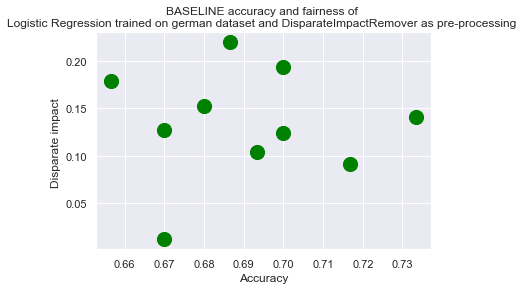

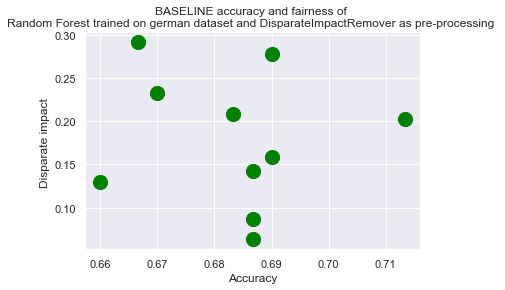

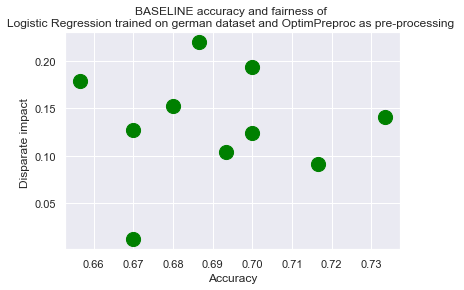

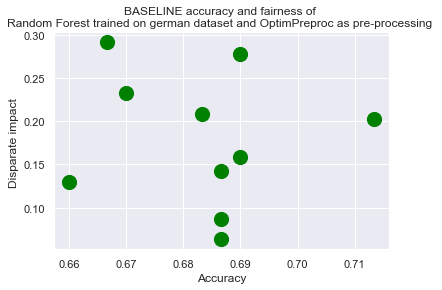

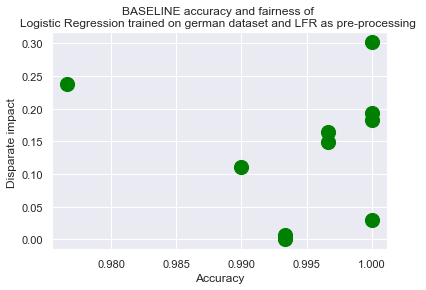

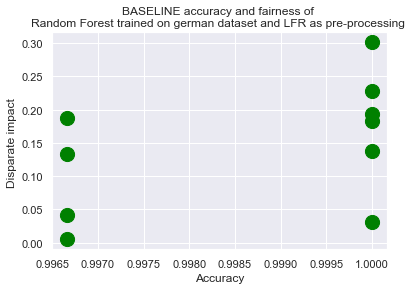

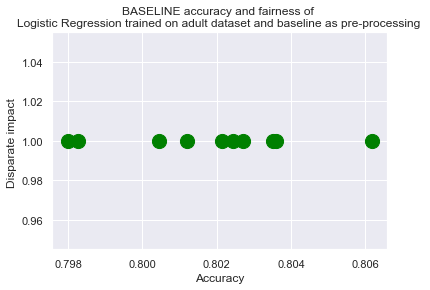

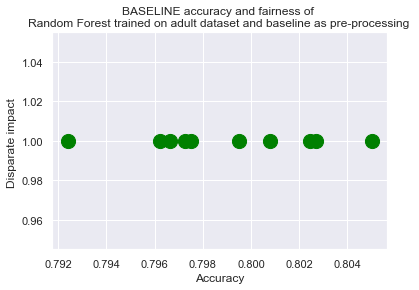

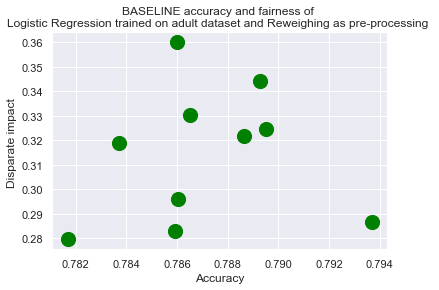

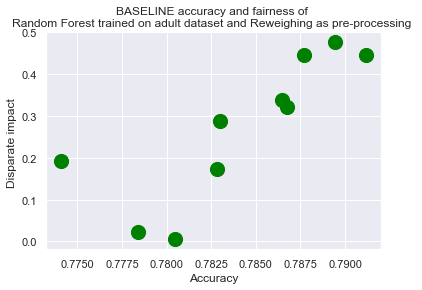

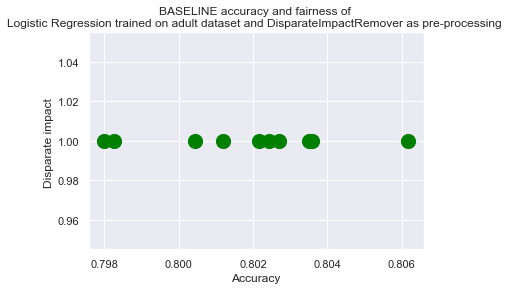

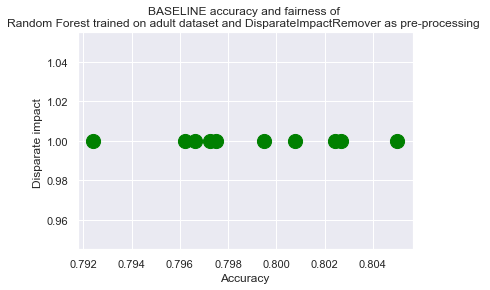

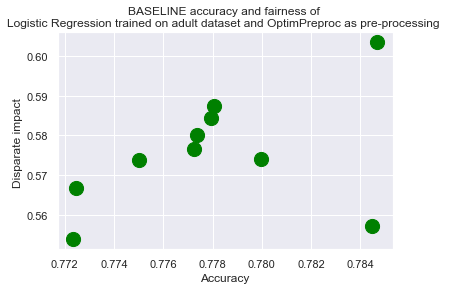

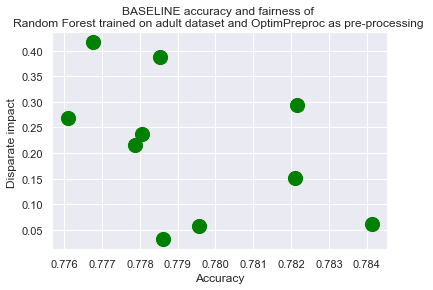

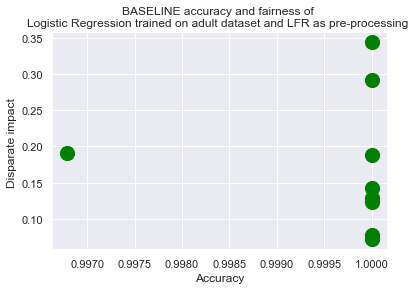

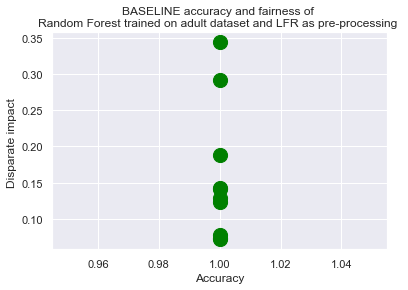

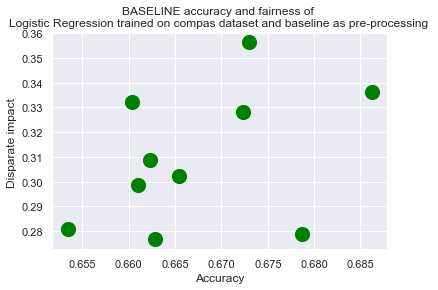

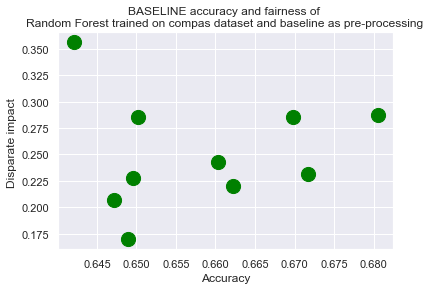

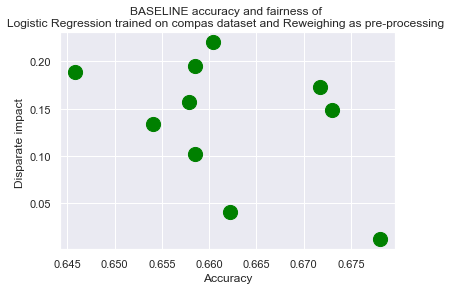

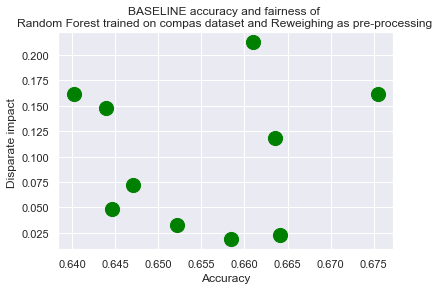

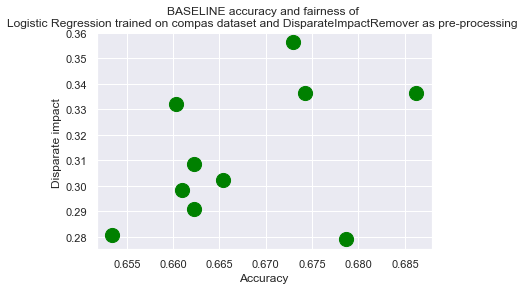

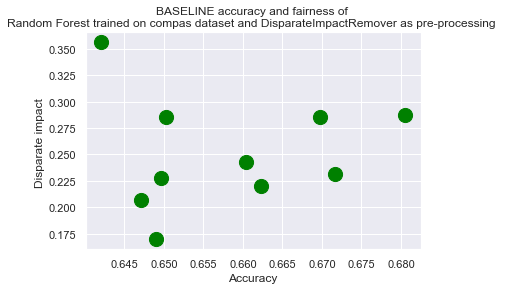

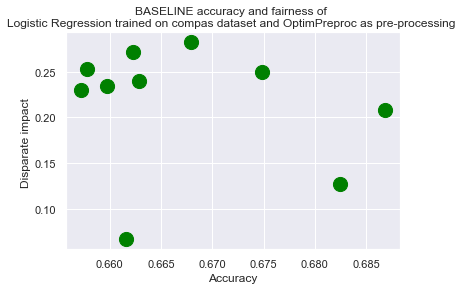

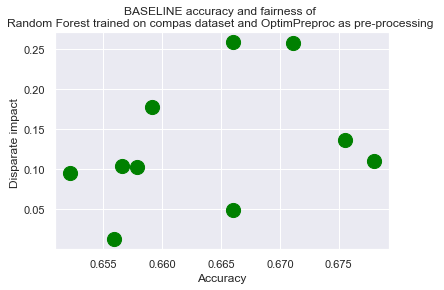

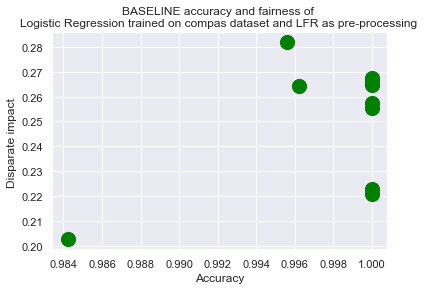

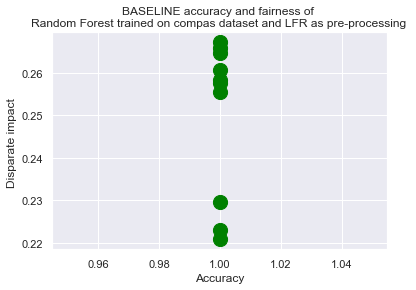

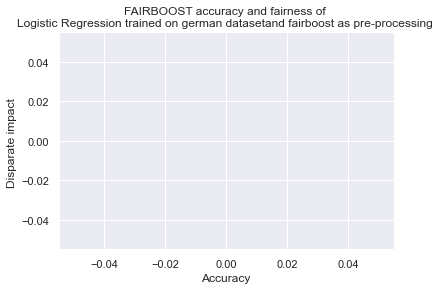

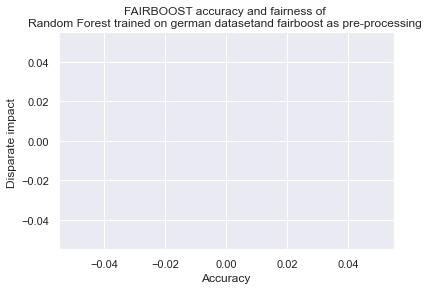

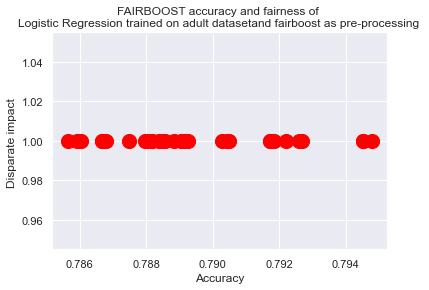

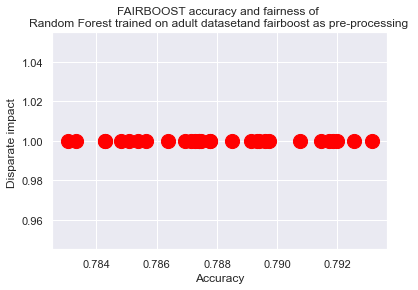

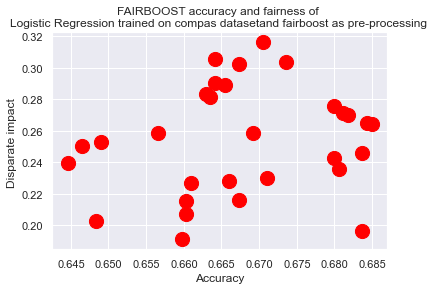

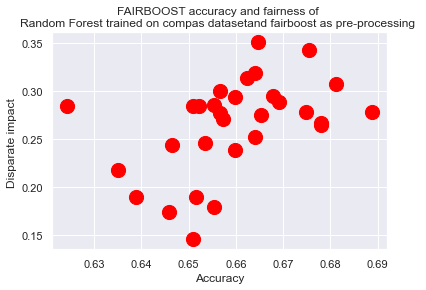

In [56]:
# Plot the metrics from baseline results using Bubble Chart

for f_ in FILE_NAME:
    for p_ in PRE_PROC_METHOD_B:
        for c_ in CLASSIFIER:
            dataset_name = f_
            pre_processing = p_
            classifier_name = c_
            
            title_ = "BASELINE accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + " and " + pre_processing+ " as pre-processing "
            
            plot_bubble(baseline_, dataset_name ,  pre_processing, classifier_name, title_ )
            

# plot the metrics from fairboost results using Bubble Chart

for f_ in FILE_NAME:
    for p_ in PRE_PROC_METHOD_F:
        for c_ in CLASSIFIER:
            dataset_name = f_
            pre_processing = p_
            classifier_name = c_

            title_ = "FAIRBOOST accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + "and " + pre_processing+ " as pre-processing "
            
            plot_bubble(fairboost_, dataset_name ,  pre_processing, classifier_name, title_ , color_ = 'red' )
            

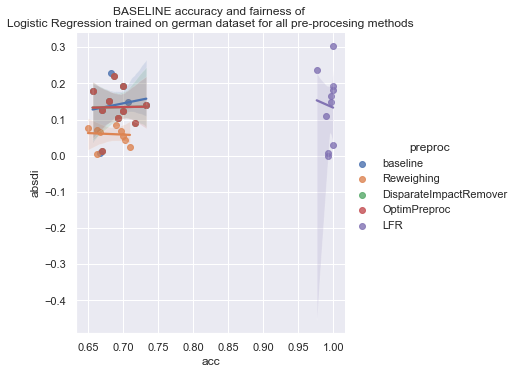

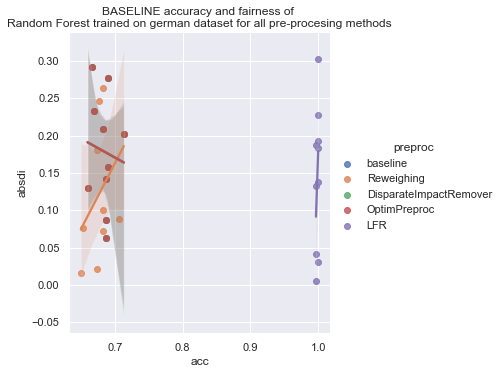

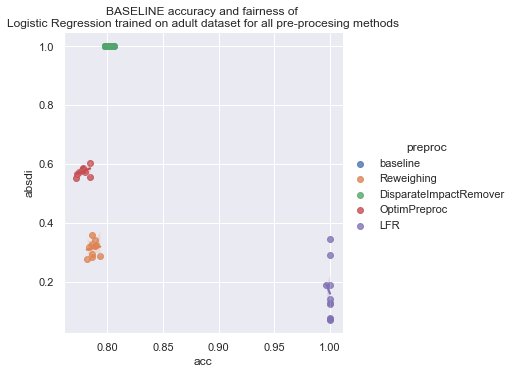

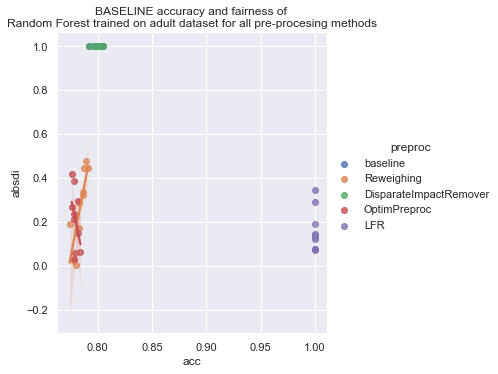

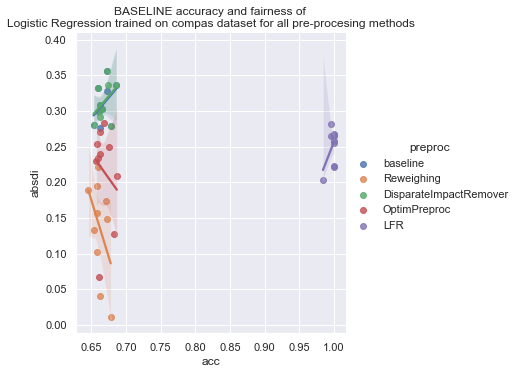

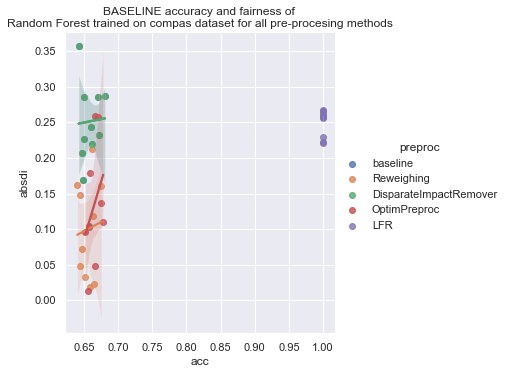

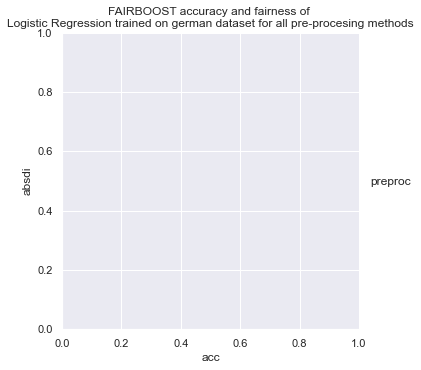

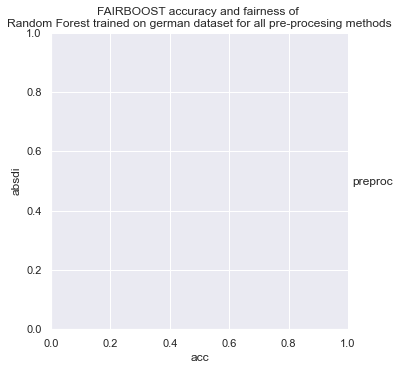

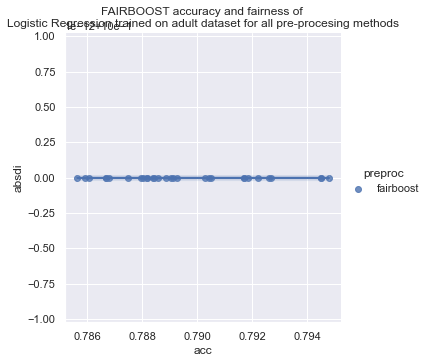

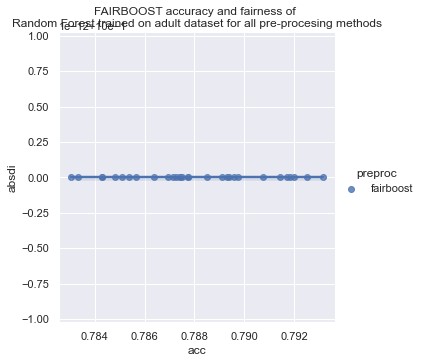

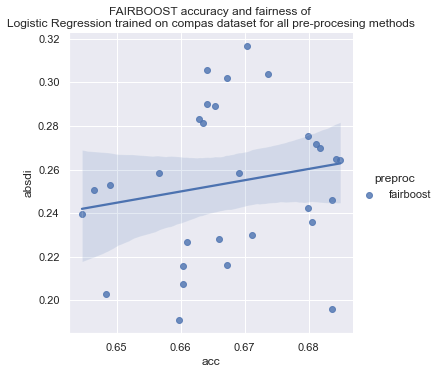

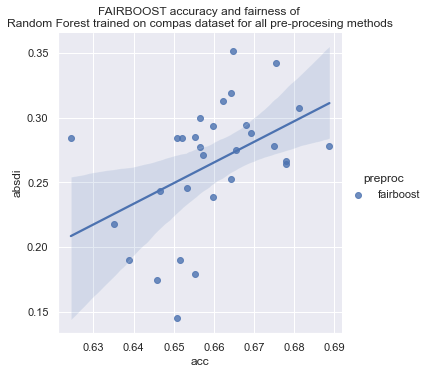

In [57]:
# Plot the metrics from BASELINE results using Markers Chart

for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        dataset_name = f_
        classifier_name = c_
            
        title_ = "BASELINE accuracy and fairness of \n" + \
            classifier_name + " trained on " + dataset_name + " dataset" + " for all pre-procesing methods"
        plot_markers(baseline_, dataset_name ,  classifier_name, title_ )    
    
# Plot the metrics from FAIRNESS results using Markers Chart
for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        dataset_name = f_
        classifier_name = c_
            
        title_ = "FAIRBOOST accuracy and fairness of \n" + \
            classifier_name + " trained on " + dataset_name + " dataset"  + " for all pre-procesing methods"
        plot_markers(fairboost_, dataset_name ,  classifier_name, title_ )

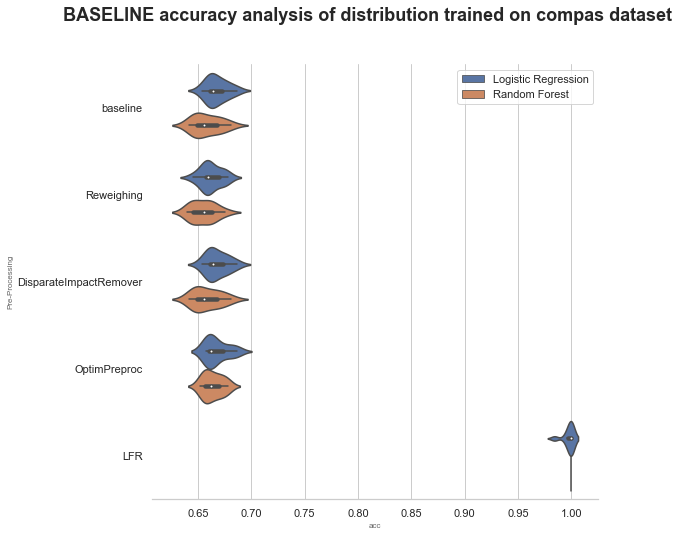

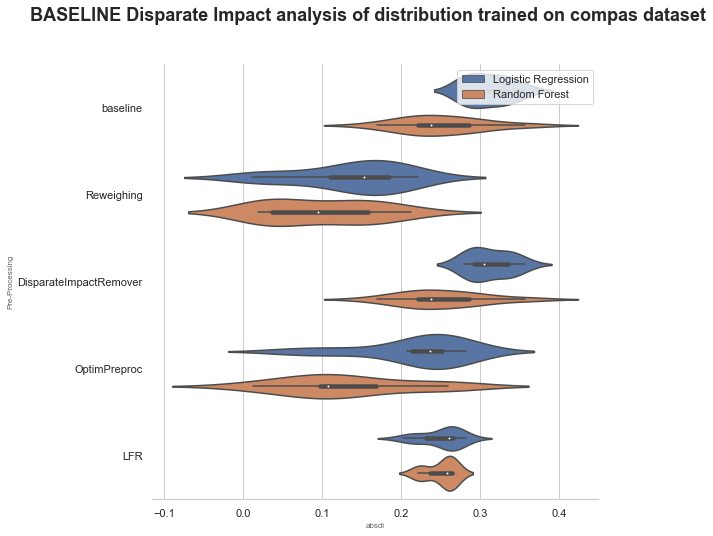

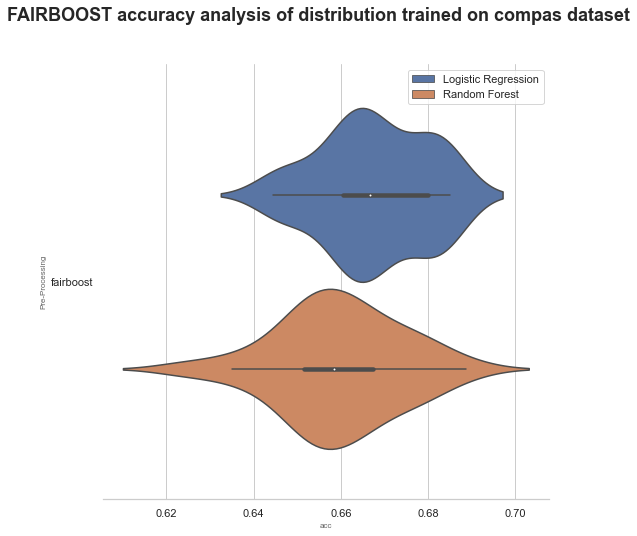

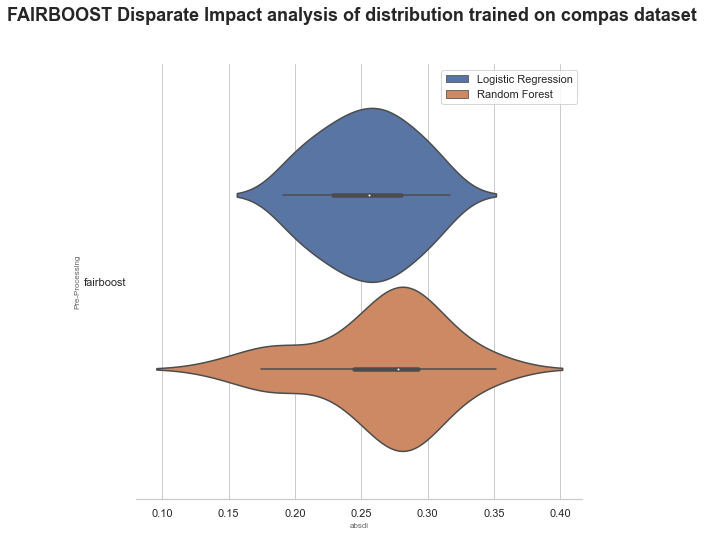

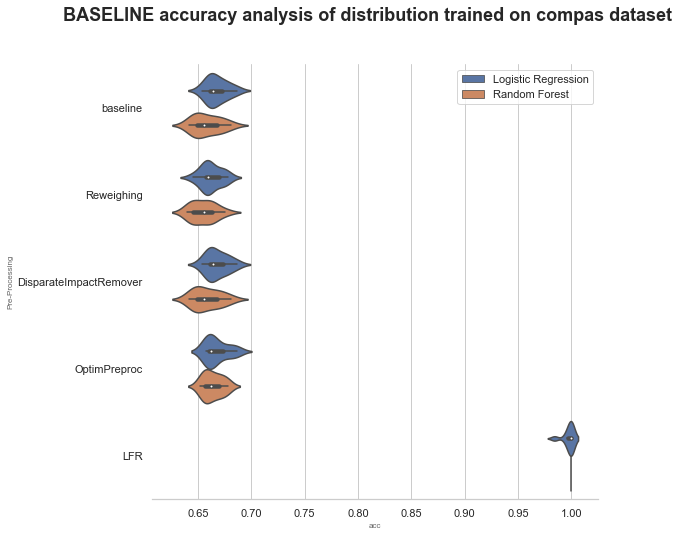

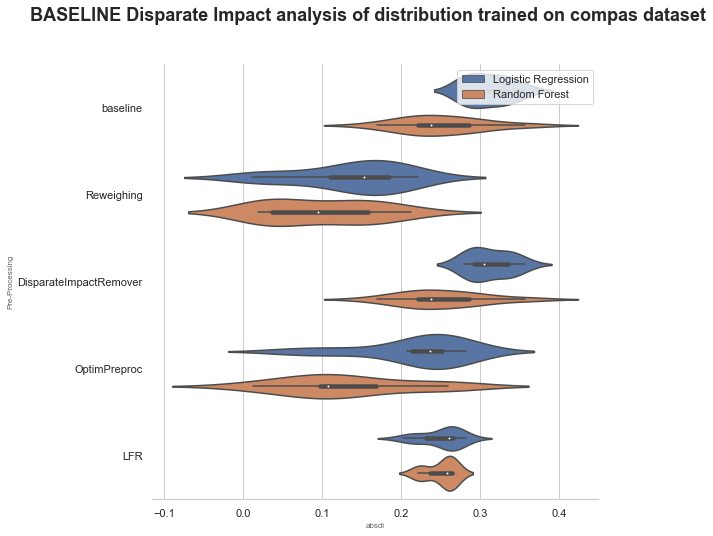

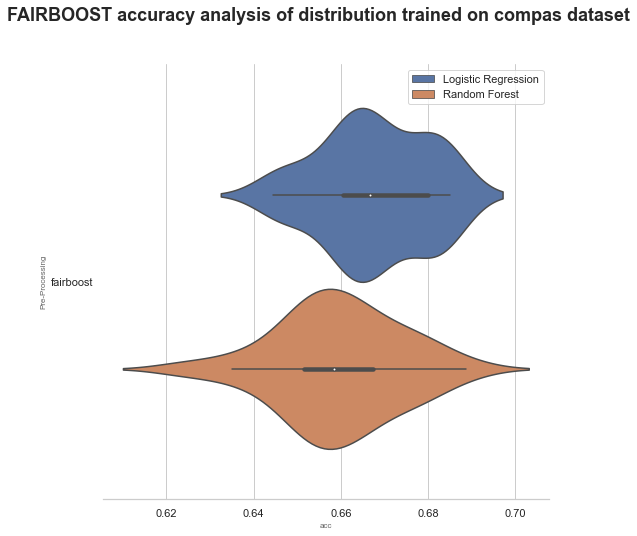

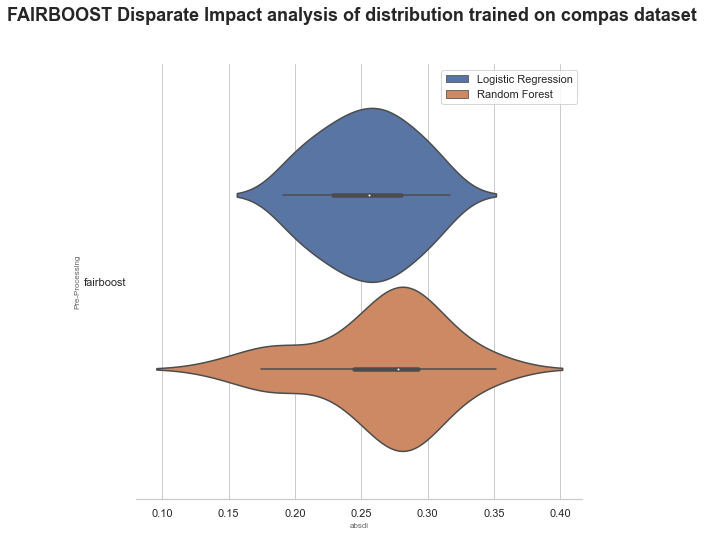

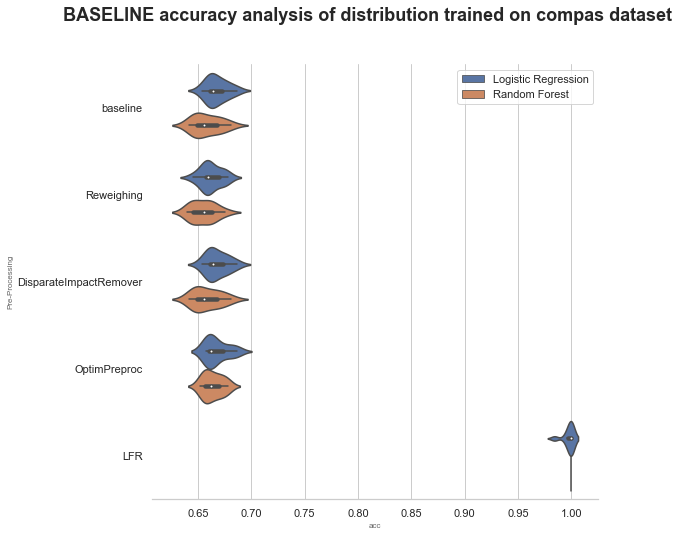

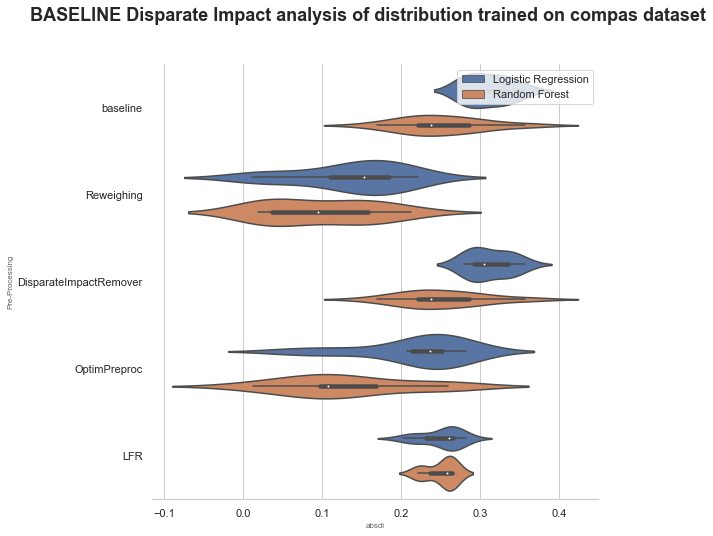

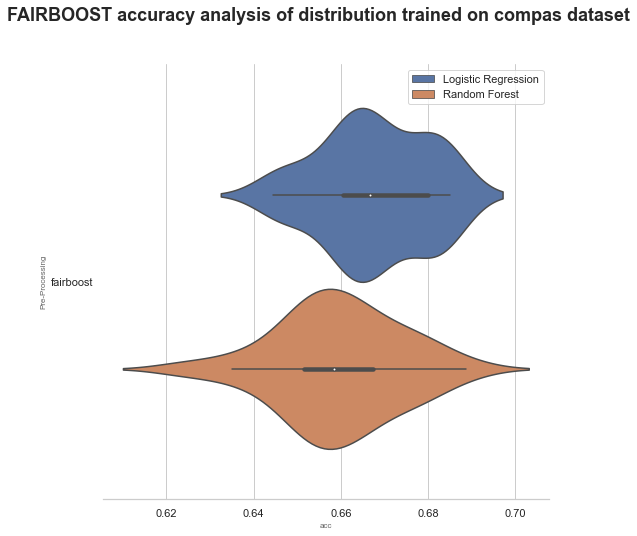

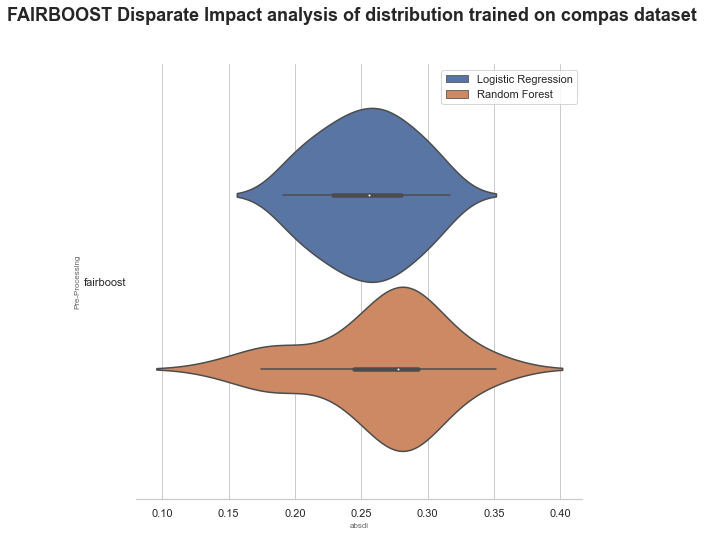

In [58]:
# Plot the metrics from baseline results using BoxPlot Chart

for f_ in FILE_NAME:
    title_ = "BASELINE accuracy analysis of distribution trained on " + dataset_name + " dataset"  
    plot_box(baseline_, dataset_name , pre_processing,  title_ )

    title_ = "BASELINE Disparate Impact analysis of distribution trained on " + dataset_name + " dataset"  
    plot_box(baseline_, dataset_name , pre_processing,  title_ ,"absdi")
    
    title_ = "FAIRBOOST accuracy analysis of distribution trained on " + dataset_name + " dataset"  
    plot_box(fairboost_, dataset_name , pre_processing,  title_ )

    title_ = "FAIRBOOST Disparate Impact analysis of distribution trained on " + dataset_name + " dataset"  
    plot_box(fairboost_, dataset_name , pre_processing,  title_, "absdi" )


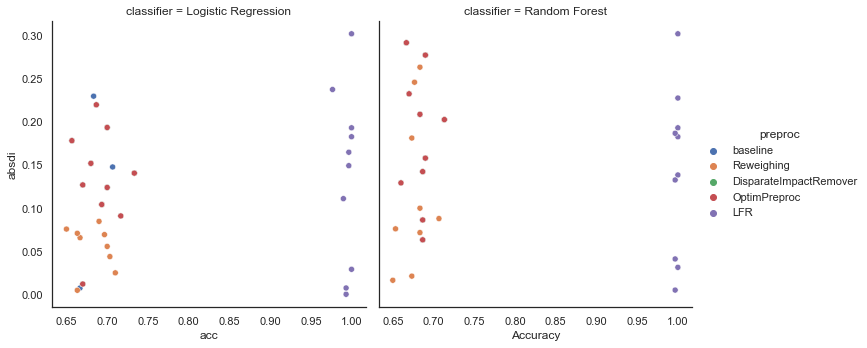

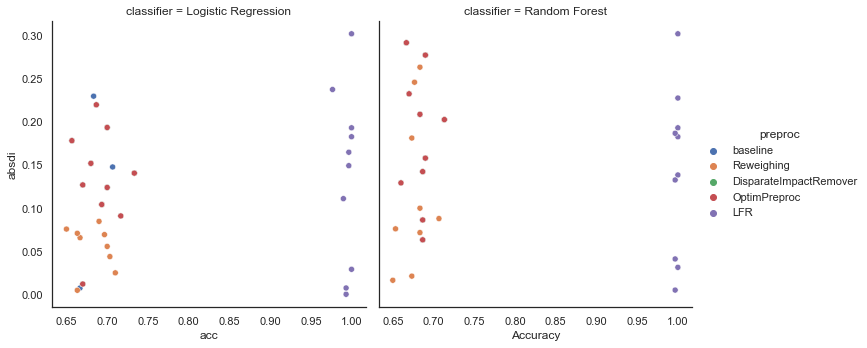

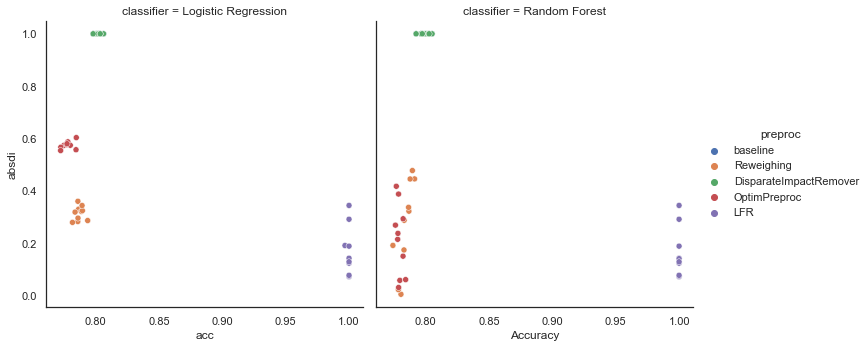

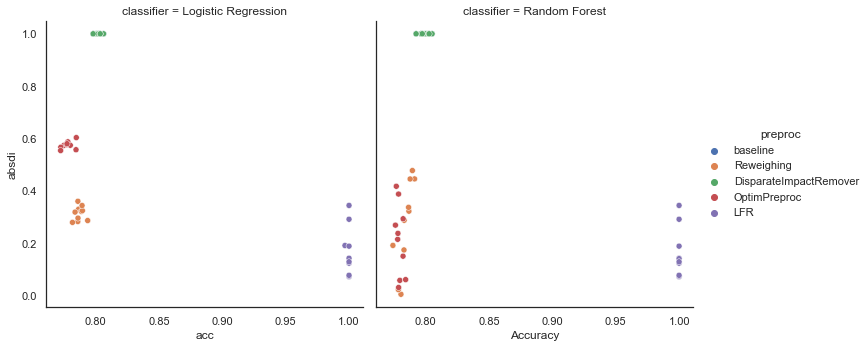

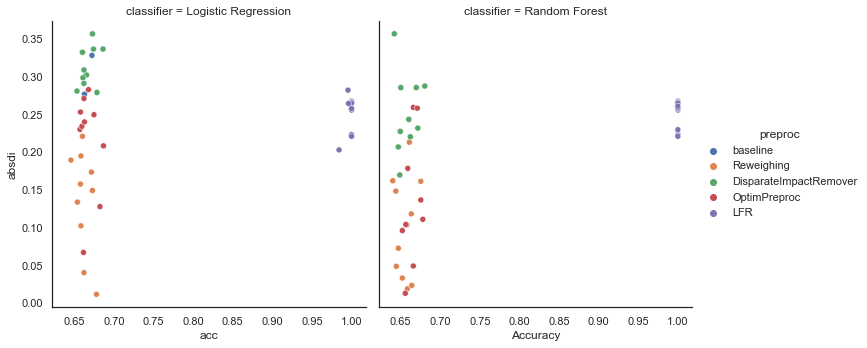

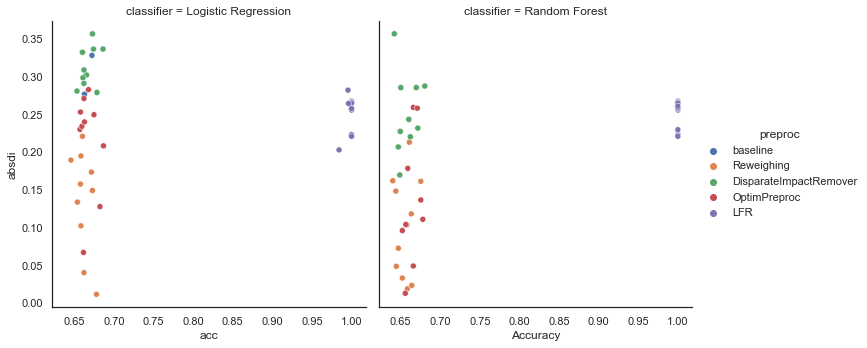

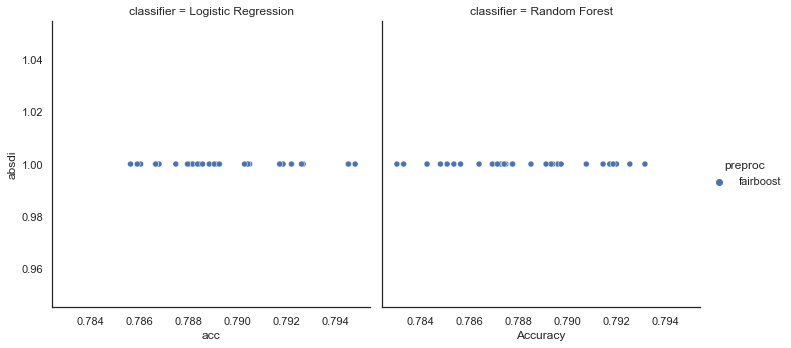

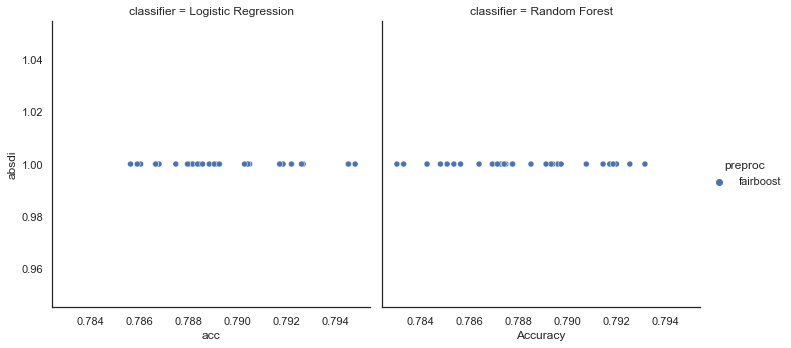

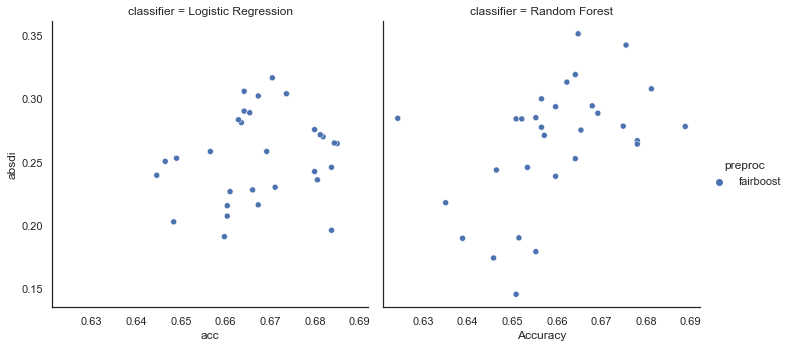

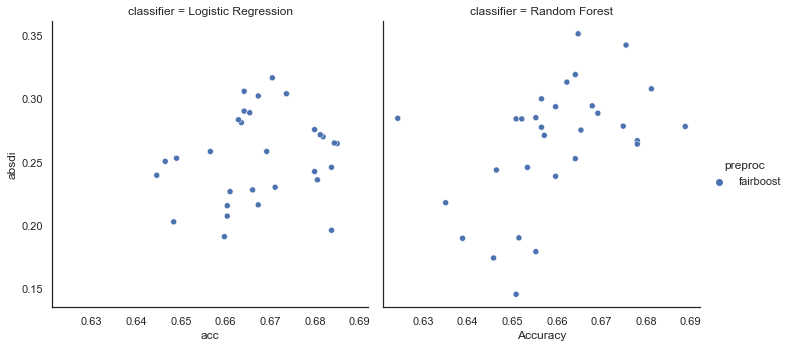

In [59]:
# Plot the metric relationship group by Pre-processing and split by Classifier
for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        title_ = "BASELINE accuracy and fairness (DI) of \n" + \
            c_ + " trained on " + f_ + " dataset"  + " for all pre-procesing methods"
        plot_relplot(baseline_,f_ , c_ , title_="")


for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        title_ = "FAIRBOOST accuracy and fairness (DI) of \n" + \
            c_ + " trained on " + f_ + " dataset"  + " for all pre-procesing methods"
        plot_relplot(fairboost_,f_, c_, title_="")


In [60]:

#@typechecked
def pareto_frontier(ObjectiveX, objectiveY, optimizeObjectiveX = True, optimizeObjectiveY = True):
    '''
    #https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/
    Method to take two equally-sized lists and return just the elements which lie 
    on the Pareto frontier, sorted into order.
    Default behaviour is to find the maximum for both X and Y, but the option is
    available to specify maxX = False or maxY = False to find the minimum for either
    or both of the parameters.
    '''
    orderedList = sorted( [[ObjectiveX[i], objectiveY[i]] for i in range(len(ObjectiveX))], reverse = optimizeObjectiveX)
    p_front = [ orderedList[0] ]    
    
    for pair in orderedList[1:]:
        if optimizeObjectiveY: 
            if pair[1] >= p_front[-1][1]:
                p_front.append(pair)
        else:
            if pair[1] <= p_front[-1][1]:
                p_front.append(pair)
    
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    
    return p_frontX, p_frontY

Accuracy: [1.0, 0.9933333333333331, 0.71, 0.7000000000000001, 0.6666666666666661, 0.663333333333333, 0.65]
DI: [0.97100641204349, 1.0, 1.024875621890547, 1.055537080146325, 1.065691251119737, 1.07077374404107, 1.075675675675675]


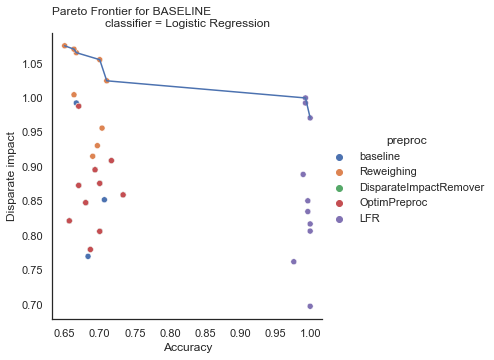

Accuracy: [1.0, 0.996666666666666, 0.65]
DI: [0.9687707641196011, 1.004878048780487, 1.016258467952058]


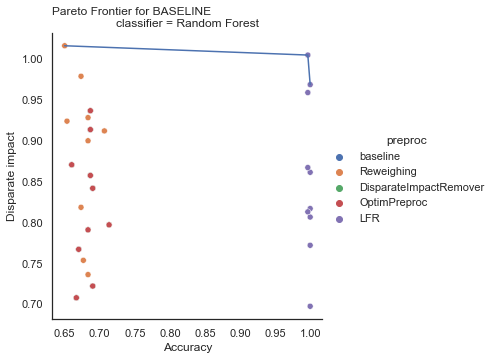

Accuracy: [1.0]
DI: [1.291521464908592]


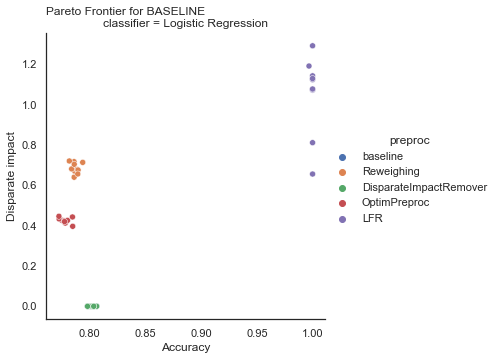

Accuracy: [1.0]
DI: [1.291521464908592]


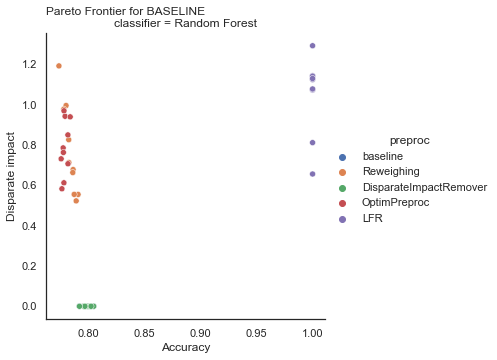

Accuracy: [1.0, 0.984217171717171, 0.682449494949494, 0.6780303030303031]
DI: [0.7791877365391341, 0.797298797409805, 0.8724202626641651, 1.011325856154581]


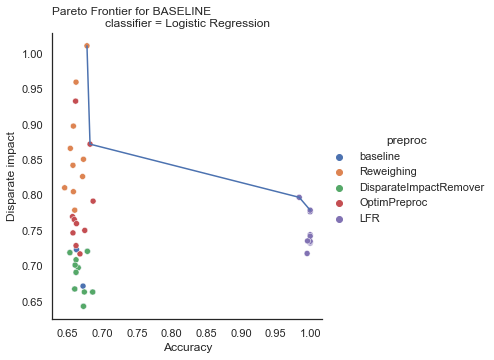

Accuracy: [1.0, 0.6780303030303031, 0.666035353535353, 0.664141414141414, 0.6521464646464641]
DI: [0.7791877365391341, 0.8893209763405551, 0.9512052264023421, 1.023084058798344, 1.032840332300439]


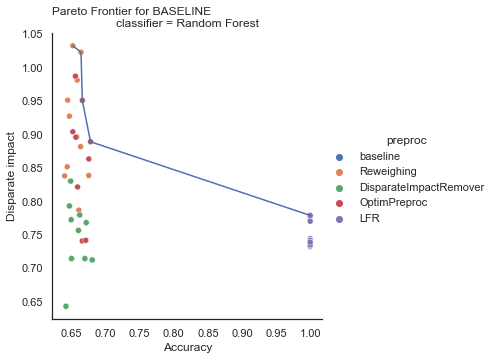

In [61]:
#Pareto for Baseline file
OPTIMIZE_ACC, OPTIMIZE_DI = True, True


for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        title_ = "Pareto Frontier for BASELINE \n"
        #plot_relplot(baseline_,f_ , c_ , title_="")
        data_ = baseline_.loc[  (baseline_['ds'] == f_) & (baseline_['classifier'] ==  c_)  ] 
        if len(data_) > 0: 
            sns.set_theme(style="white")
            sns.relplot(x="acc", y="di", hue="preproc",  col="classifier" ,data=data_)
            plt.ylabel("Disparate impact")
            plt.xlabel("Accuracy")
            plt.title(title_, loc='left')
            #plt.show()

            #data_ = baseline_.loc[  (baseline_['ds'] == f_) & (baseline_['classifier'] ==  c_)  ] 
            Xs =  data_['acc'].to_numpy() 
            Ys =  data_['di'].to_numpy() 

            p_front =pareto_frontier(Xs, Ys, OPTIMIZE_ACC, OPTIMIZE_DI)
            print (f"Accuracy: {p_front[0]}")
            print (f"DI: {p_front[1]}")
            plt.plot(p_front[0], p_front[1])
            plt.show()
        


Accuracy: [0.794786050638094, 0.79451306899611, 0.79451306899611, 0.792670442912714, 0.792602197502217, 0.7921927250392411, 0.79185149798676, 0.791715007165768, 0.791715007165768, 0.7904865897768371, 0.7904183443663411, 0.7902818535453491, 0.7892581723879071, 0.7891216815669141, 0.7890534361564181, 0.78884869992493, 0.788575718282945, 0.788439227461953, 0.7883709820514571, 0.7881662458199681, 0.7881662458199681, 0.7880297549989761, 0.7879615095884801, 0.787483791715007, 0.7868013376100451, 0.786664846789053, 0.786664846789053, 0.7860506380945881, 0.7859141472735951, 0.785641165631611]
DI: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


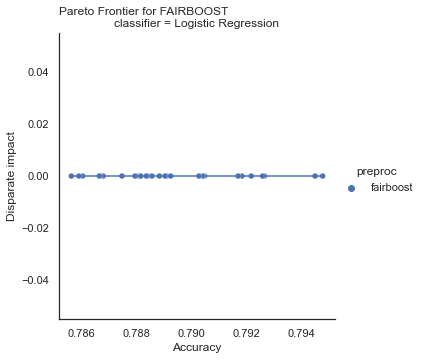

Accuracy: [0.7931481607861871, 0.7925339520917211, 0.791987988807752, 0.79185149798676, 0.791715007165768, 0.7914420255237831, 0.790759571418822, 0.789735890261379, 0.789599399440387, 0.7893946632088991, 0.7893264177984031, 0.7891216815669141, 0.788507472872449, 0.787756773356991, 0.787756773356991, 0.787483791715007, 0.787415546304511, 0.787415546304511, 0.7872790554835181, 0.7871425646625261, 0.7869378284310381, 0.786391865147068, 0.785641165631611, 0.785368183989626, 0.7850952023476421, 0.7848222207056571, 0.784276257421688, 0.784276257421688, 0.783320821674742, 0.7830478400327571]
DI: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


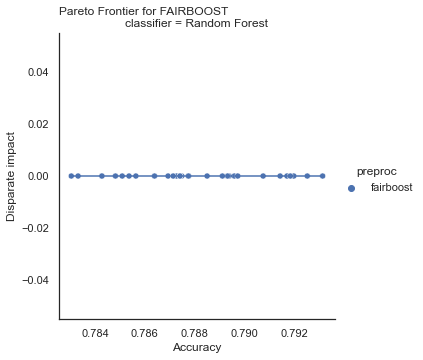

Accuracy: [0.6849747474747471, 0.6837121212121211, 0.6597222222222221]
DI: [0.735419218349849, 0.803799112707229, 0.8088429970876351]


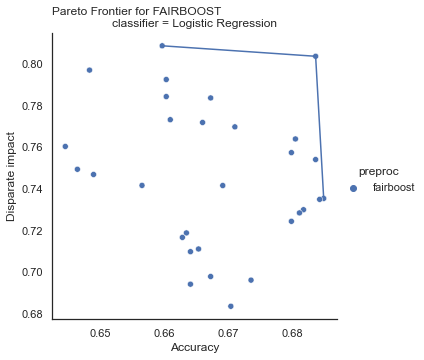

Accuracy: [0.6887626262626261, 0.6780303030303031, 0.664141414141414, 0.6597222222222221, 0.65530303030303, 0.650883838383838]
DI: [0.721939179641211, 0.735824175824175, 0.7473271094725571, 0.7612344404955851, 0.820654087900149, 0.854285894346394]


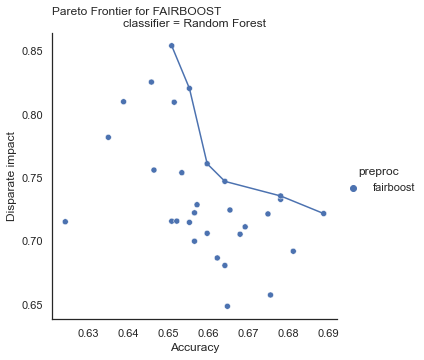

In [62]:
#Pareto for Fairboost file
OPTIMIZE_ACC, OPTIMIZE_DI = True, True
for f_ in FILE_NAME:
    for c_ in CLASSIFIER:
        title_ = "Pareto Frontier for FAIRBOOST \n"
        #plot_relplot(baseline_,f_ , c_ , title_="")
        data_ = fairboost_.loc[  (fairboost_['ds'] == f_) & (fairboost_['classifier'] ==  c_)  ] 
        if len(data_) > 0: 
            sns.set_theme(style="white")
            sns.relplot(x="acc", y="di", hue="preproc",  col="classifier" ,data=data_)
            plt.ylabel("Disparate impact")
            plt.xlabel("Accuracy")
            plt.title(title_, loc='left')
            #plt.show()

            Xs =  data_['acc'].to_numpy() 
            Ys =  data_['di'].to_numpy() 

            p_front =pareto_frontier(Xs, Ys, OPTIMIZE_ACC, OPTIMIZE_DI)
            print (f"Accuracy: {p_front[0]}")
            print (f"DI: {p_front[1]}")
            plt.plot(p_front[0], p_front[1])
            plt.show()